In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Use inspector to get the column names and data type
inspector = inspect(engine)
columns =inspector.get_columns('measurement')
for column in columns:
     print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).order_by(Measurement.date.desc()).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2590ebd97c8>,
 'id': 2724,
 'date': '2017-08-23',
 'tobs': 81.0,
 'prcp': 0.0,
 'station': 'USC00519397'}

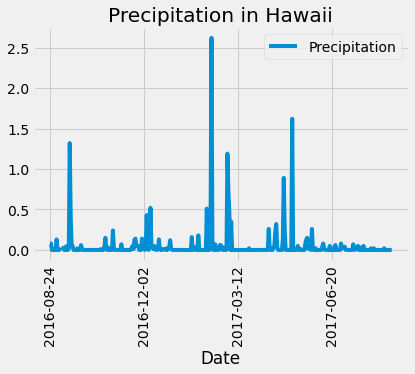

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017,8,23)
# Calculate the date one year from the last date in data set.
query_date = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date)

# Save the query results as a Pandas DataFrame andsort the data by date
measurement_df = pd.read_sql_query(
    sql = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date).group_by(Measurement.date).order_by(Measurement.date).statement,
    con = engine
)

# Rename columns, set the index as the date
measurement_df = measurement_df.rename(columns={"date":"Date","prcp":"Precipitation"})
measurement_df.set_index(measurement_df["Date"], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(title="Precipitation in Hawaii",rot=90);


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_measurement_df = pd.read_sql_query(
    sql = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date).statement,
    con = engine
)
all_measurement_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Identify the data available
columns =inspector.get_columns('station')
for column in columns:
     print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.id).count()
print(total_stations)

9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station,func.count(Measurement.date)).group_by(Measurement.station).all()
print(station_count)

[('USC00511918', 1979), ('USC00513117', 2709), ('USC00514830', 2202), ('USC00516128', 2612), ('USC00517948', 1372), ('USC00518838', 511), ('USC00519281', 2772), ('USC00519397', 2724), ('USC00519523', 2669)]


In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average precipitation.
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"The lowest precipitation is {lowest_temp}")
print(f"The highest precipitation is {highest_temp}")
print(f"The average precipitation is {avg_temp}")

The lowest precipitation is [(54.0,)]
The highest precipitation is [(85.0,)]
The average precipitation is [(71.66378066378067,)]


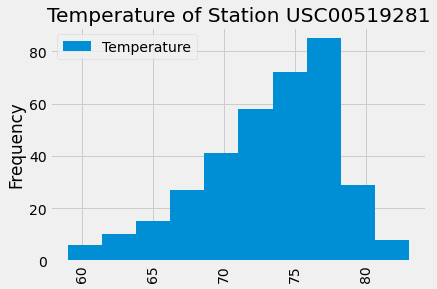

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_df = pd.read_sql_query(
    sql = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > query_date).filter(Measurement.station == 'USC00519281').statement,
    con = engine
)
USC00519281_df = USC00519281_df.rename(columns={"date":"Date","tobs":"Temperature"})
USC00519281_df.set_index(USC00519281_df["Date"], inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
USC00519281_df.plot.hist(title="Temperature of Station USC00519281",rot=90);

# Close session

In [19]:
# Close Session
session.close()